In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tf_model.h5
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/pytorch_model.bin
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/vocab.txt
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/flax_model.msgpack
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/._bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/pytorch_model.bin
/

## <b><span style='color:#F1A425'>Import Library</span></b>


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import regex as re
import emoji
import string

In [3]:
column_names = ['Tweet_ID','Entity','Sentiment','Tweet_content']
train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',header=None, names = column_names)
validation = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',header=None, names = column_names)

## <b><span style='color:#F1A425'>EDA on Data</span></b>


#### How data looks

In [4]:
# see the columns in the loaded data
train.keys()

Index(['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_content'], dtype='object')

In [5]:
# printing top 5
train.head(5)

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


#### <b><span style='color:#F1A425'>Removing null values</span></b>


In [6]:
# finding null values in both training and validation data
train.isnull().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

In [7]:
validation.isnull().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

In [8]:
train.dropna(subset=['Tweet_content'], inplace=True)

In [9]:
train.isnull().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

Removed all invalid tweet entries

#### <b><span style='color:#F1A425'>Removing duplicates</span></b>


In [10]:
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet_content'], keep='first')
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet_content'], keep='first')

In [11]:
train.shape

(70958, 4)

#### <b><span style='color:#F1A425'>Exploring the dataset count of each sentiment</span></b>

In [12]:
train.Sentiment.value_counts()

Negative      21565
Positive      19549
Neutral       17398
Irrelevant    12446
Name: Sentiment, dtype: int64

In [13]:
validation.Sentiment.value_counts()

Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: Sentiment, dtype: int64

In [14]:
def get_distribution_sentiment(data, title):
    # Calculate the value counts of the 'Sentiment' column
    sentiment_counts = data['Sentiment'].value_counts()

    # Create a pie chart
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')

    # Add a title
    plt.title(f"Sentiment Distribution {title}")

    # Display the chart;
    plt.show()

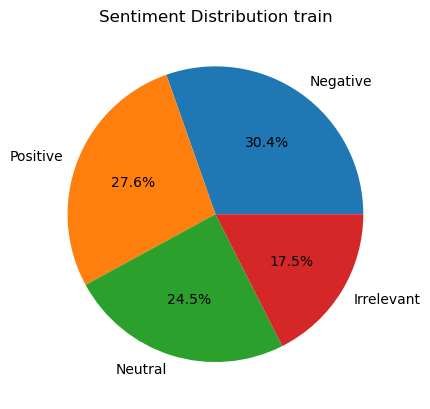

In [15]:
get_distribution_sentiment(train, "train")

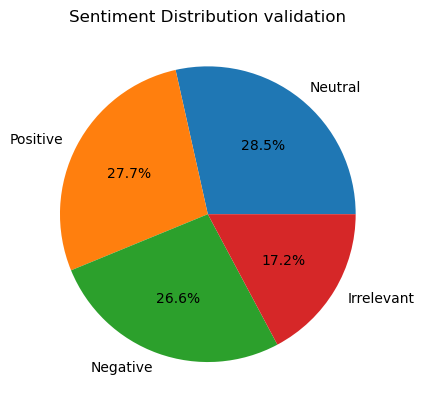

In [16]:
get_distribution_sentiment(validation, "validation")

### <b><span style='color:#F1A425'>Cleaning the text</span></b>

In [17]:
def draw_word_cloud(data, label):
    word_cloud_text = ''.join(data[data["Sentiment"]==label].Tweet_content)
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    #Figure properties
    plt.figure(figsize=(6,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

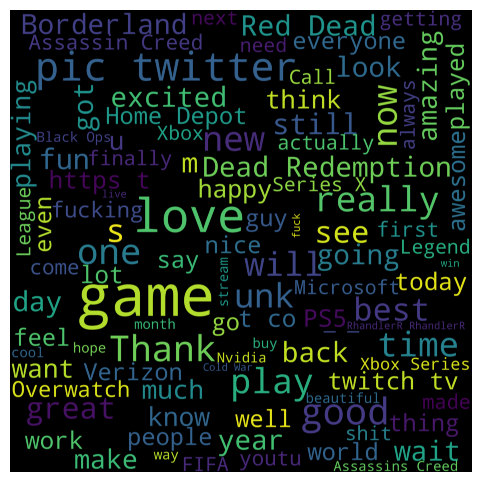

In [18]:
draw_word_cloud(train, "Positive")

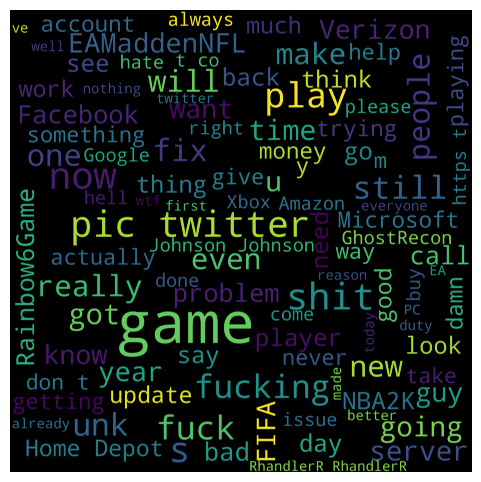

In [19]:
draw_word_cloud(train, "Negative")

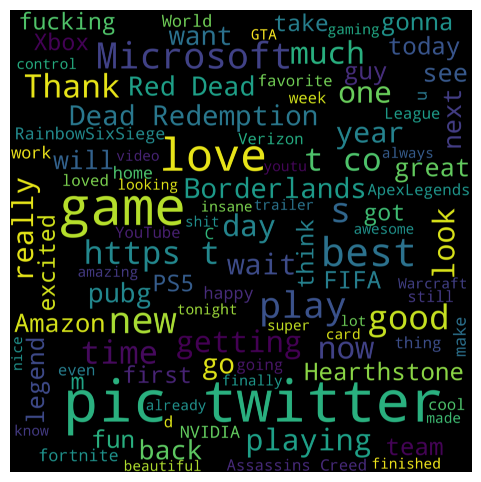

In [20]:
draw_word_cloud(validation, "Positive")

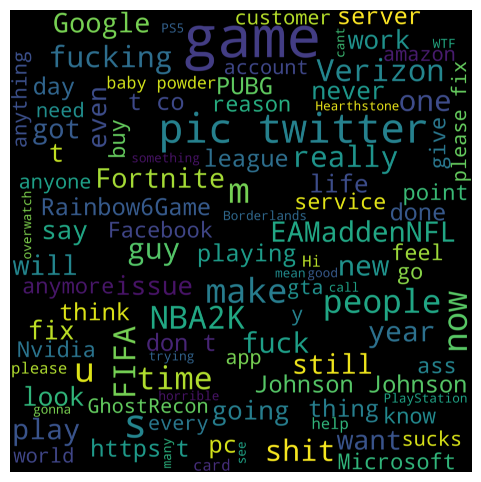

In [21]:
draw_word_cloud(validation, "Negative")

### <b><span style='color:#F1A425'>Cleaning the text</span></b>

In [22]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    emoji_pattern = emoji.demojize(text)
    return re.sub(r":[a-zA-Z_]+:", "", emoji_pattern)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def clean_text(t):
    return remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t)))))

In [23]:
texts_new = []
for t in train.Tweet_content:
    texts_new.append(clean_text(t))
train['cleaned_tweet'] = [text.lower() for text in texts_new]

In [24]:
texts_new = []
for t in validation.Tweet_content:
    texts_new.append(clean_text(t))
validation['cleaned_tweet'] = texts_new

### <b><span style='color:#F1A425'>Checking for tweets less than 1 words after cleaning</span></b>

In [25]:
def add_len_cleaned(df):
    text_len = []
    for text in df.cleaned_tweet:
        tweet_len = len(text.split())
        text_len.append(tweet_len)
    df['text_len'] = text_len
    return df

In [26]:
train = add_len_cleaned(train).copy()

In [27]:
validation = add_len_cleaned(validation).copy()

In [28]:
def plot_tweets(df, words = 10):
    plt.figure(figsize=(7,5))
    ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
    plt.title('Training tweets with less than 10 words')
    plt.yticks([])
    ax.bar_label(ax.containers[0])
    plt.ylabel('count')
    plt.xlabel('')
    plt.show()

In [29]:
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


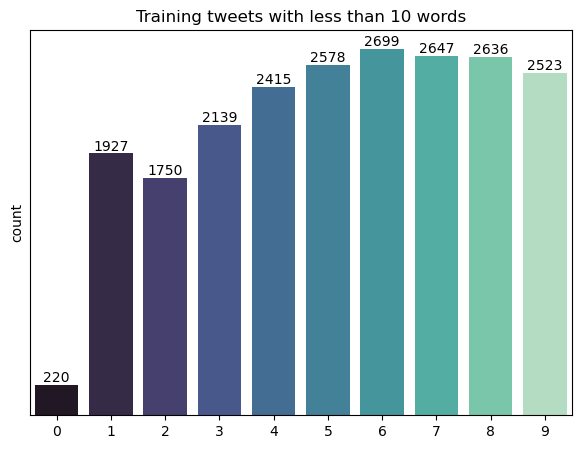

In [30]:
plot_tweets(train)

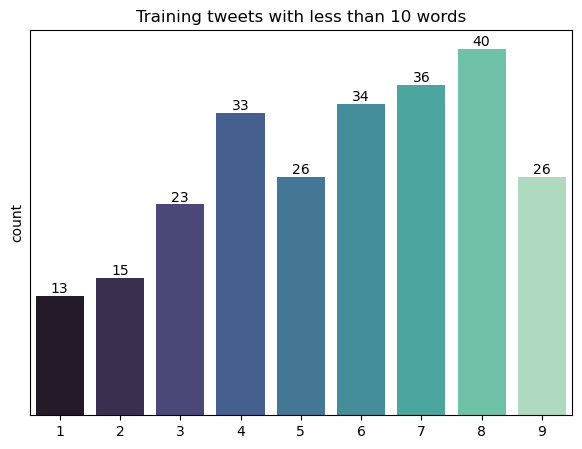

In [31]:
plot_tweets(validation)

In [32]:
train.shape

(70958, 6)

In [33]:
validation.shape

(1000, 6)

In [34]:
train = train[train['text_len'] > 4]
train.shape

(62507, 6)

In [35]:
validation = validation[validation['text_len'] > 4]
validation.shape

(916, 6)

In [36]:
train_shuffled = train.sample(frac=1, random_state=42)  # Set a random_state for reproducibility
n_train_samples = int(len(train) * 0.8)

# Split the DataFrame into training and test sets
train = train_shuffled.iloc[:n_train_samples]
test = train_shuffled.iloc[n_train_samples:]

# Optional: Reset the DataFrame index
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [37]:
train.shape

(50005, 6)

In [38]:
test.shape

(12502, 6)

In [39]:
validation.shape

(916, 6)

### <b><span style='color:#F1A425'>Modelling</span></b>

In [40]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [41]:
train.keys()

Index(['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_content', 'cleaned_tweet',
       'text_len'],
      dtype='object')

In [42]:
data_train = train[['Tweet_content', 'Sentiment']]
data_test = test[['Tweet_content', 'Sentiment']]
# Set your model output as categorical and save in new label col
data_train['Sentiment_label'] = pd.Categorical(data_train['Sentiment'])
data_test['Sentiment_label'] = pd.Categorical(data_test['Sentiment'])

# Transform your output to numeric
data_train['Sentiment'] = data_train['Sentiment_label'].cat.codes
data_test['Sentiment'] = data_test['Sentiment_label'].cat.codes

/tmp/ipykernel_23/832129695.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Sentiment_label'] = pd.Categorical(data_train['Sentiment'])
/tmp/ipykernel_23/832129695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Sentiment_label'] = pd.Categorical(data_test['Sentiment'])
/tmp/ipykernel_23/832129695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [43]:
data_train.head(10)

,Tweet_content,Sentiment,Sentiment_label
0,"Oops, got caught making people think it’s a fu...",1,Negative
1,first five astrazeneca now plus j & j... we we...,1,Negative
2,i still wanna know the reason root put TFT mis...,1,Negative
3,No search and destruction? Wow!,3,Positive
4,Verizon looking for violent racist woman who w...,1,Negative
5,Everything about this film sounds SO GOOD..,0,Irrelevant
6,After saying that I won't buy another Fifa gam...,3,Positive
7,Ban for Battlefield 4 player JoCeRWorld has oc...,0,Irrelevant
8,Nice to share the start day with @ Nvidia. and...,2,Neutral
9,i need to actually get some artwork moving and...,1,Negative


In [44]:
data_test.head(10)

,Tweet_content,Sentiment,Sentiment_label
0,"Well we hit 600 followers, thanks guys!",3,Positive
1,"Congratulations to all nominees, including our...",2,Neutral
2,I really like the design of the PS5. It really...,3,Positive
3,"Apex Legends - 1 4, 350 Apex Blue Coins [ Onli...",2,Neutral
4,for Switch Pro games as strong rumour boosts P...,2,Neutral
5,@nvidia it’s ridiculous – very soon as I get y...,1,Negative
6,It is no secret that I love Assassins Creed. I...,3,Positive
7,Cry for help: how horror makes you happy and h...,2,Neutral
8,youtu.be/c-aixISTD2U. Again 47 apps banned. PU...,1,Negative
9,"When I saw Kattegat, I knew that shit had beco...",3,Positive


In [45]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")



In [47]:
# Extract the training and testing texts and labels
train_texts = data_train['Tweet_content'].tolist()
train_labels = data_train['Sentiment'].tolist()
test_texts = data_test['Tweet_content'].tolist()
test_labels = data_test['Sentiment'].tolist()

In [48]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert the labels to one-hot encoding
num_labels = len(data_train['Sentiment_label'].cat.categories)


In [49]:
num_labels

4

In [50]:
train_labels_encoded = tf.one_hot(train_labels, num_labels)
test_labels_encoded = tf.one_hot(test_labels, num_labels)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_encoded))


In [51]:
# Use smaller batch size
batch_size = 16

model_1 = TFDistilBertModel.from_pretrained("../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
# Tokenize the texts

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model_1(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :])  # Pooling the output

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model_1 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_1.fit(train_dataset.batch(batch_size), epochs=2)

# Evaluate the model
model_1.evaluate(test_dataset.batch(batch_size))
model_1.save("/kaggle/working/models/BERT_batch_16_epochs_2")

Some layers from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3126/3126 [==============================] - 473s 144ms/step - loss: 0.8604 - accuracy: 0.6508
Epoch 2/2
782/782 [==============================] - 41s 51ms/step - loss: 0.3664 - accuracy: 0.8757


In [52]:
# Use smaller batch size
model_2 = TFDistilBertModel.from_pretrained("../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
# Tokenize the texts

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model_2(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :])  # Pooling the output

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model_2 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

batch_size = 32

model_2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_2.fit(train_dataset.batch(batch_size), epochs=2)

# Evaluate the model
model_2.evaluate(test_dataset.batch(batch_size))

model_2.save("/kaggle/working/models/BERT_batch_32_epochs_2")

Some layers from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 412s 249ms/step - loss: 0.9046 - accuracy: 0.6308
Epoch 2/2
391/391 [==============================] - 35s 86ms/step - loss: 0.4408 - accuracy: 0.8452


In [53]:
# Use smaller batch size
model_3 = TFDistilBertModel.from_pretrained("../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
# Tokenize the texts

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model_3(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :])  # Pooling the output

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model_3 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

batch_size = 32

model_3.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_3.fit(train_dataset.batch(batch_size), epochs=5)

# Evaluate the model
model_3.evaluate(test_dataset.batch(batch_size))

model_3.save("/kaggle/working/models/BERT_batch_32_epochs_10")

Some layers from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 396s 239ms/step - loss: 0.9137 - accuracy: 0.6265
Epoch 2/5
1563/1563 [==============================] - 368s 236ms/step - loss: 0.5210 - accuracy: 0.8048
Epoch 3/5
1563/1563 [==============================] - 369s 236ms/step - loss: 0.2505 - accuracy: 0.9143
Epoch 4/5
1563/1563 [==============================] - 367s 235ms/step - loss: 0.1260 - accuracy: 0.9582
Epoch 5/5
391/391 [==============================] - 35s 86ms/step - loss: 0.2534 - accuracy: 0.9305


In [54]:
# Use smaller batch size
model_4 = TFDistilBertModel.from_pretrained("../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
# Tokenize the texts

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model_4(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :])  # Pooling the output

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model_4 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

batch_size = 16

model_4.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_4.fit(train_dataset.batch(batch_size), epochs=5)

# Evaluate the model
model_4.evaluate(test_dataset.batch(batch_size))

model_4.save("/kaggle/working/models/BERT_batch_16_epochs_10")

Some layers from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3126/3126 [==============================] - 456s 139ms/step - loss: 0.8593 - accuracy: 0.6521
Epoch 2/5
3126/3126 [==============================] - 412s 132ms/step - loss: 0.4106 - accuracy: 0.8497
Epoch 3/5
3126/3126 [==============================] - 412s 132ms/step - loss: 0.1676 - accuracy: 0.9443
Epoch 4/5
3126/3126 [==============================] - 413s 132ms/step - loss: 0.0833 - accuracy: 0.9722
Epoch 5/5
782/782 [==============================] - 44s 53ms/step - loss: 0.2483 - accuracy: 0.9342


In [55]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def predict_values(model):
    train_predictions = model.predict(train_dataset.batch(64))
    train_predicted_labels = np.argmax(train_predictions, axis=1)
    test_predictions = model.predict(test_dataset.batch(64))
    test_predicted_labels = np.argmax(test_predictions, axis=1)
    return train_predicted_labels, test_predicted_labels

def draw_confusion_matrix(model, train_predicted_labels, test_predicted_labels):
    

    # Convert the predicted labels to their original sentiment categories
    train_predicted_sentiments = data_train['Sentiment_label'].cat.categories[train_predicted_labels]
    test_predicted_sentiments = data_test['Sentiment_label'].cat.categories[test_predicted_labels]

    # Convert the true labels to their original sentiment categories
    train_true_labels = data_train['Sentiment_label']
    test_true_labels = data_test['Sentiment_label']

    # Calculate the classification report for the training set
    train_classification_rep = classification_report(train_true_labels, train_predicted_sentiments)
    print("Training Set - Classification Report:\n", train_classification_rep)

    # Generate the confusion matrix for the training set
    train_confusion_mat = confusion_matrix(train_true_labels, train_predicted_sentiments)

    # Get the unique labels/categories from the true labels
    labels = np.unique(train_true_labels)

    # Plot the confusion matrix for the training set
    train_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_mat, display_labels=labels)
    train_display.plot(cmap='Blues') 
    plt.title("Training Set - Confusion Matrix")
    plt.grid(False)
    plt.show()

    # Calculate the classification report for the test set
    test_classification_rep = classification_report(test_true_labels, test_predicted_sentiments)
    print("Test Set - Classification Report:\n", test_classification_rep)

    # Generate the confusion matrix for the test set
    test_confusion_mat = confusion_matrix(test_true_labels, test_predicted_sentiments)

    # Plot the confusion matrix for the test set
    test_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mat, display_labels=labels)
    test_display.plot(cmap='Blues')
    plt.title("Test Set - Confusion Matrix")
    plt.grid(False)
    plt.show()
    # Load and preprocess the data
    data_val = validation[['Tweet_content', 'Sentiment']]
    data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
    data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes





    # Extract the training and testing texts and labels
    val_texts = data_val['Tweet_content'].tolist()
    val_labels = data_val['Sentiment'].tolist()

    # Tokenize the texts
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

    # Convert the labels to one-hot encoding
    num_labels = len(data_val['Sentiment_label'].cat.categories)
    val_labels_encoded = tf.one_hot(val_labels, num_labels)

    # Create TensorFlow datasets
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))

    # Make predictions on the training and test datasets

    val_predictions = model.predict(val_dataset.batch(64))
    val_predicted_labels = np.argmax(val_predictions, axis=1)

    # Convert the predicted labels to their original sentiment categories
    val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

    # Convert the true labels to their original sentiment categories
    val_true_labels = data_val['Sentiment_label']

    # Calculate the classification report for the training set
    val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
    print("Training Set - Classification Report:\n", val_classification_rep)

    # Generate the confusion matrix for the training set
    val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

    # Get the unique labels/categories from the true labels
    labels = np.unique(val_true_labels)

    # Plot the confusion matrix for the training set
    val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
    val_display.plot(cmap='Blues') 
    plt.title("Validation Set - Confusion Matrix")
    plt.grid(False)
    plt.show()


In [56]:
train_predicted_labels, test_predicted_labels = predict_values(model_1)

196/196 [==============================] - 30s 151ms/step


In [57]:
train_predicted_labels_2, test_predicted_labels_2 = predict_values(model_2)

196/196 [==============================] - 29s 150ms/step


Training Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.96      0.88      0.92      8864
    Negative       0.95      0.96      0.96     15198
     Neutral       0.89      0.96      0.92     12669
    Positive       0.95      0.93      0.94     13274

    accuracy                           0.94     50005
   macro avg       0.94      0.93      0.93     50005
weighted avg       0.94      0.94      0.94     50005



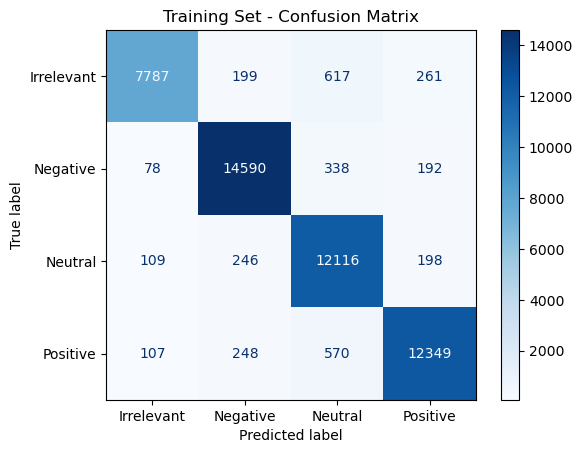

Test Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.89      0.73      0.80      2215
    Negative       0.88      0.90      0.89      3836
     Neutral       0.77      0.88      0.82      3182
    Positive       0.86      0.83      0.85      3269

    accuracy                           0.85     12502
   macro avg       0.85      0.83      0.84     12502
weighted avg       0.85      0.85      0.84     12502



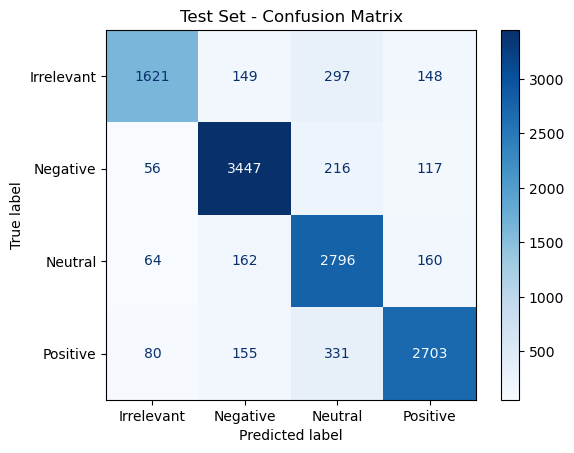

/tmp/ipykernel_23/1719351141.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
/tmp/ipykernel_23/1719351141.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes


15/15 [==============================] - 4s 144ms/step
Training Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.96      0.85      0.90       161
    Negative       0.94      0.94      0.94       244
     Neutral       0.86      0.93      0.89       275
    Positive       0.93      0.93      0.93       236

    accuracy                           0.92       916
   macro avg       0.92      0.91      0.92       916
weighted avg       0.92      0.92      0.92       916



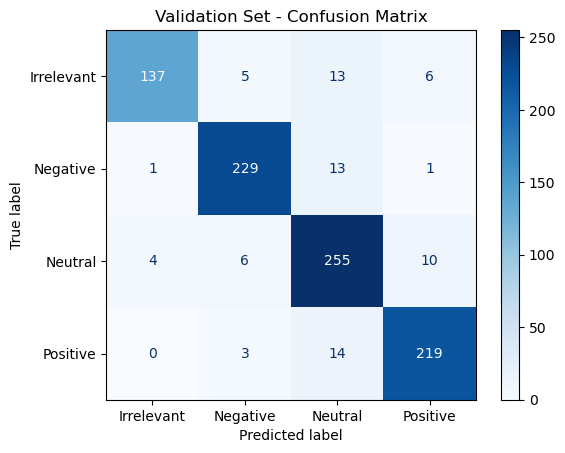

In [58]:
draw_confusion_matrix(model_2, train_predicted_labels_2, test_predicted_labels_2)

In [59]:
train_predicted_labels_3, test_predicted_labels_3 = predict_values(model_3)

196/196 [==============================] - 29s 150ms/step


Training Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       1.00      0.99      1.00      8864
    Negative       1.00      1.00      1.00     15198
     Neutral       0.99      1.00      0.99     12669
    Positive       1.00      1.00      1.00     13274

    accuracy                           1.00     50005
   macro avg       1.00      1.00      1.00     50005
weighted avg       1.00      1.00      1.00     50005



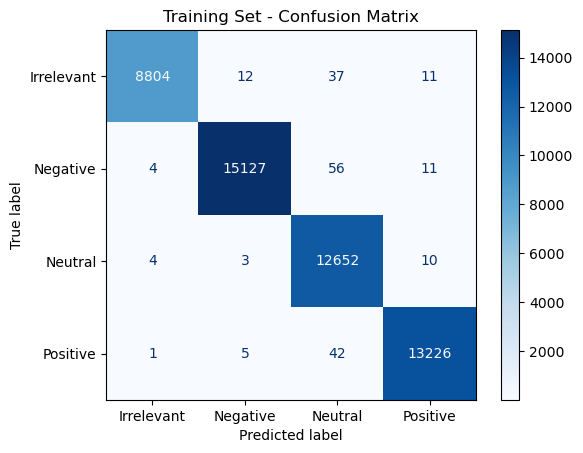

Test Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.95      0.89      0.92      2215
    Negative       0.95      0.94      0.95      3836
     Neutral       0.91      0.94      0.93      3182
    Positive       0.91      0.94      0.93      3269

    accuracy                           0.93     12502
   macro avg       0.93      0.93      0.93     12502
weighted avg       0.93      0.93      0.93     12502



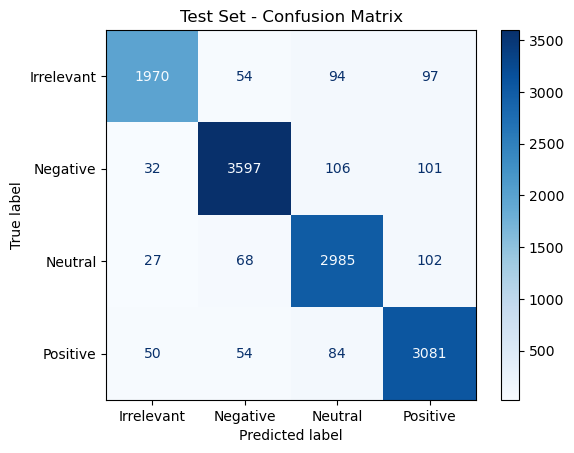

/tmp/ipykernel_23/1719351141.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
/tmp/ipykernel_23/1719351141.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes


15/15 [==============================] - 4s 144ms/step
Training Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.95      0.93      0.94       161
    Negative       0.98      0.97      0.97       244
     Neutral       0.95      0.94      0.95       275
    Positive       0.94      0.97      0.96       236

    accuracy                           0.96       916
   macro avg       0.95      0.95      0.95       916
weighted avg       0.96      0.96      0.96       916



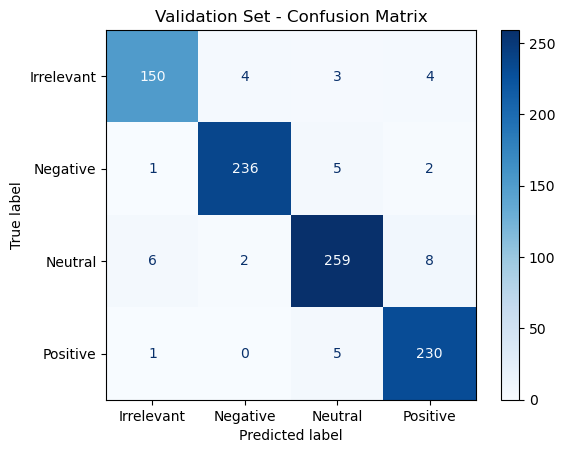

In [60]:
draw_confusion_matrix(model_3, train_predicted_labels_3, test_predicted_labels_3)

In [61]:
train_predicted_labels_4, test_predicted_labels_4 = predict_values(model_4)

196/196 [==============================] - 29s 150ms/step


Training Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       1.00      0.99      1.00      8864
    Negative       1.00      1.00      1.00     15198
     Neutral       0.99      1.00      0.99     12669
    Positive       1.00      0.99      1.00     13274

    accuracy                           1.00     50005
   macro avg       1.00      1.00      1.00     50005
weighted avg       1.00      1.00      1.00     50005



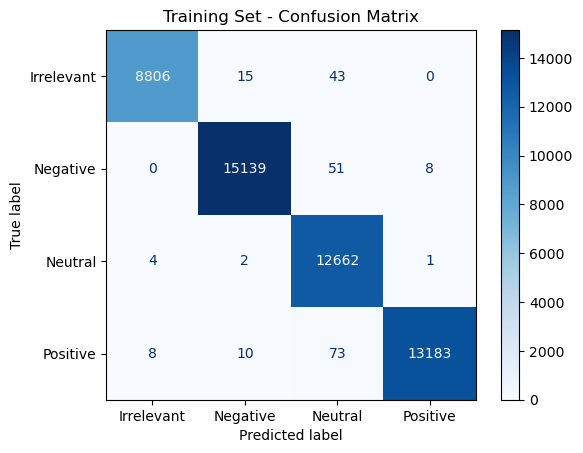

Test Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.96      0.90      0.93      2215
    Negative       0.95      0.95      0.95      3836
     Neutral       0.89      0.97      0.93      3182
    Positive       0.95      0.90      0.93      3269

    accuracy                           0.93     12502
   macro avg       0.94      0.93      0.93     12502
weighted avg       0.94      0.93      0.93     12502



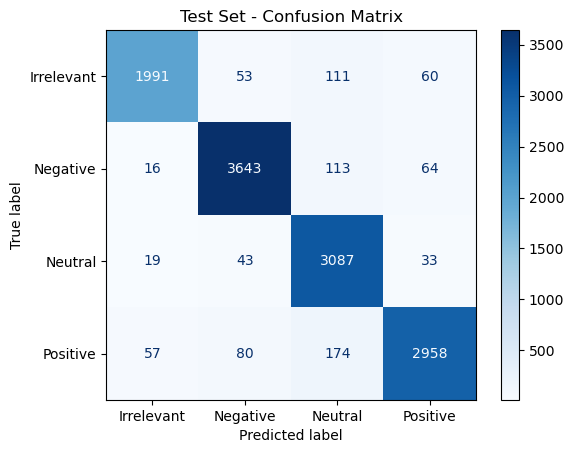

/tmp/ipykernel_23/1719351141.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
/tmp/ipykernel_23/1719351141.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes


15/15 [==============================] - 4s 143ms/step
Training Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.97      0.93      0.95       161
    Negative       0.97      0.97      0.97       244
     Neutral       0.94      0.97      0.96       275
    Positive       0.97      0.96      0.96       236

    accuracy                           0.96       916
   macro avg       0.96      0.96      0.96       916
weighted avg       0.96      0.96      0.96       916



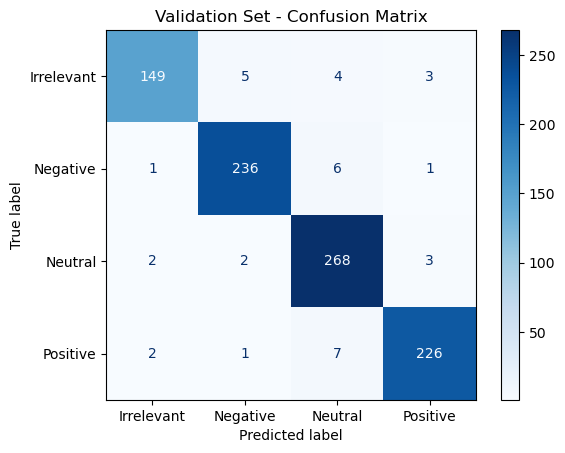

In [62]:
draw_confusion_matrix(model_4, train_predicted_labels_4, test_predicted_labels_4)

Training Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.98      0.92      0.95      8864
    Negative       0.96      0.98      0.97     15198
     Neutral       0.95      0.97      0.96     12669
    Positive       0.96      0.97      0.97     13274

    accuracy                           0.96     50005
   macro avg       0.97      0.96      0.96     50005
weighted avg       0.96      0.96      0.96     50005



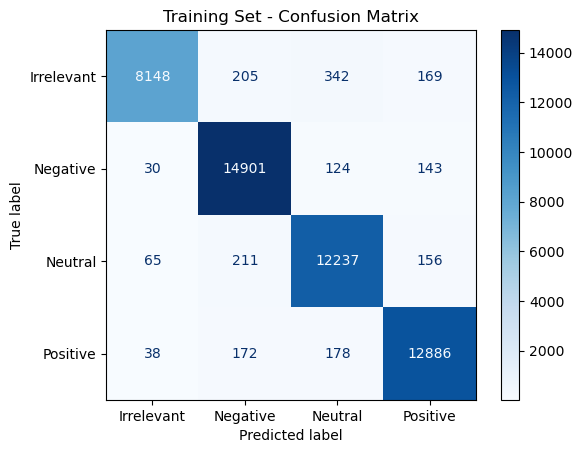

Test Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.92      0.77      0.84      2215
    Negative       0.88      0.93      0.90      3836
     Neutral       0.85      0.87      0.86      3182
    Positive       0.88      0.89      0.88      3269

    accuracy                           0.88     12502
   macro avg       0.88      0.87      0.87     12502
weighted avg       0.88      0.88      0.87     12502



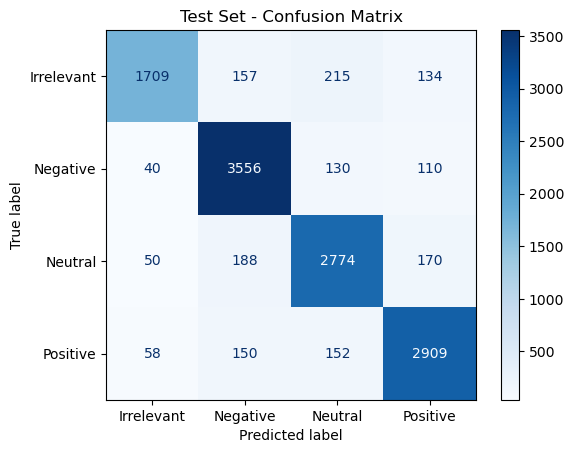

/tmp/ipykernel_23/1719351141.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
/tmp/ipykernel_23/1719351141.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes


15/15 [==============================] - 4s 144ms/step
Training Set - Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.95      0.86      0.90       161
    Negative       0.95      0.95      0.95       244
     Neutral       0.93      0.93      0.93       275
    Positive       0.94      0.98      0.96       236

    accuracy                           0.94       916
   macro avg       0.94      0.93      0.94       916
weighted avg       0.94      0.94      0.94       916



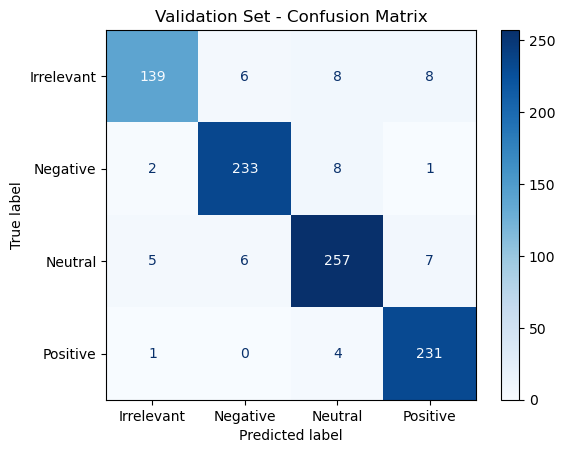

In [63]:
draw_confusion_matrix(model_1, train_predicted_labels, test_predicted_labels)